## Generate hierarchical clustering artwork and haplotype groups
- using whole genome phasing 
- based upon Ag1000g phase 1 paper

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust
from scipy.cluster.hierarchy import _convert_to_double
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy

## Setup data

In [2]:
# # define the gene region
# region = 'PARA'
# region_vgsc = '2L', 2358158, 2431617

In [3]:
callset_haps = np.load('../data/haps_phase2.npz')

In [4]:
haps = allel.HaplotypeArray(callset_haps['haplotypes'])

In [5]:
haps.shape

(390588, 2284)

In [6]:
pos = allel.SortedIndex(callset_haps['POS'])

In [7]:
#define region
start = 2358158
stop = 2431617

In [8]:
# locate the region of interest
loc = pos.locate_range(start, stop)

In [9]:
# obtain haplotypes for the region of interest
pos = pos[loc]
h = haps[loc]

In [10]:
h.shape

(2092, 2284)

In [11]:
#setup missense
tbl_variants_selected = etl.frompickle('../data/tbl_variants_missense_selected.pkl')

tbl_selected_redux = (
    tbl_variants_selected
    .cut('POS', 'REF', 'ALT', 'AGAP004707-RA')
    .mergeduplicates(key=('POS'))
    .convert('ALT', lambda v: ','.join(v) if len(v) > 1 else v)
    #.addfield('label',  lambda rec: '%s:%s>%s %s' % (rec.POS, rec.REF, rec.ALT.ljust(3), rec['AGAP004707-RA'].rjust(6)))
    .addfield('label',  lambda rec: '%s:%s>%s' % (rec.POS, rec.REF, rec.ALT.ljust(3)))
    .sort('POS')
)

In [12]:
tbl_selected_redux

0|POS,1|REF,2|ALT,3|AGAP004707-RA,4|label
2390177,G,A,R254K,2390177:G>A
2391228,G,"T,C",V402L,"2391228:G>T,C"
2399997,G,C,D466H,2399997:G>C
2400071,G,"A,T",M490I,"2400071:G>A,T"
2402466,G,T,G531V,2402466:G>T


In [13]:
# extract positions for the missense variants
pos_missense = allel.SortedIndex(tbl_selected_redux['POS'])

# extract haplotypes for the missense variants
missense_bool = np.in1d(pos, pos_missense)
h_missense = h.compress(missense_bool)

missense_mutations = list(tbl_selected_redux['AGAP004707-RA'])

## Plot missense mutations

In [14]:
h_missense

<HaplotypeArray shape=(21, 2284) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 1 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 2 0 0 2
0 0 1 0 0 ... 0 0 0 0 0

In [15]:
def plot_missense_haplotypes(ax, h, mut_labels):
    h = h.copy()
    # colours for colormap
    mycol = ['r', 'w', 'k'] 
    # alter rows with kdr mutations for color map to pick up
#     known_muts = ['L995S (2984T>C)', 'L995F (2985A>T)', 'N1570Y (4708A>T)']
    known_muts = ['L995S', 'L995F', 'N1570Y']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=3)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=1, zorder=-10)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    lbl = [l for l in mut_labels[::-1]]
    ax.set_yticklabels(lbl, family='monospace', fontsize=6)
    ax.set_ylabel('Non-synonymous SNPs')
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('r')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
    ax.yaxis.tick_left()
    ax.set_xticks([])
    # rasterize to avoid SVG antialiasing issues and reduce file size
    ax.set_rasterization_zorder(-5)

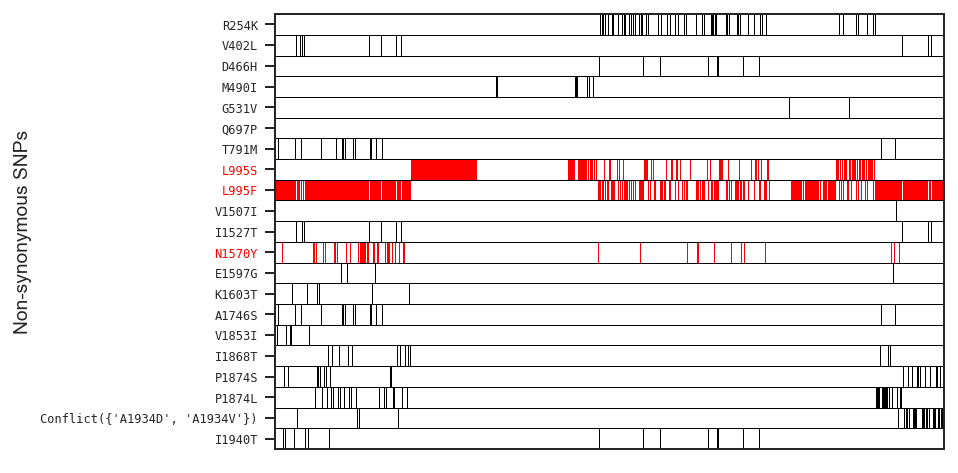

In [16]:
fig, ax = plt.subplots()
plot_missense_haplotypes(ax, h_missense, missense_mutations)

In [17]:
#fixes multiallelic name conflict
missense_mutations[-2] = 'A1934D'

In [18]:
missense_mutations

['R254K',
 'V402L',
 'D466H',
 'M490I',
 'G531V',
 'Q697P',
 'T791M',
 'L995S',
 'L995F',
 'V1507I',
 'I1527T',
 'N1570Y',
 'E1597G',
 'K1603T',
 'A1746S',
 'V1853I',
 'I1868T',
 'P1874S',
 'P1874L',
 'A1934D',
 'I1940T']

## Cluster haplotypes

/home/chris/malariagen/binder/conda/envs/ag1000g-phase2-vgsc-report-c668a73/lib/python3.6/site-packages/seaborn/utils.py:247: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  maj_on = any(t.tick1On for t in ax_i.xaxis.majorTicks)
/home/chris/malariagen/binder/conda/envs/ag1000g-phase2-vgsc-report-c668a73/lib/python3.6/site-packages/seaborn/utils.py:248: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  min_on = any(t.tick1On for t in ax_i.xaxis.minorTicks)
/home/chris/malariagen/binder/conda/envs/ag1000g-phase2-vgsc-report-c668a73/lib/python3.6/site-packages/seaborn/utils.py:251: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = maj_on
/home/chris/malariagen/binde

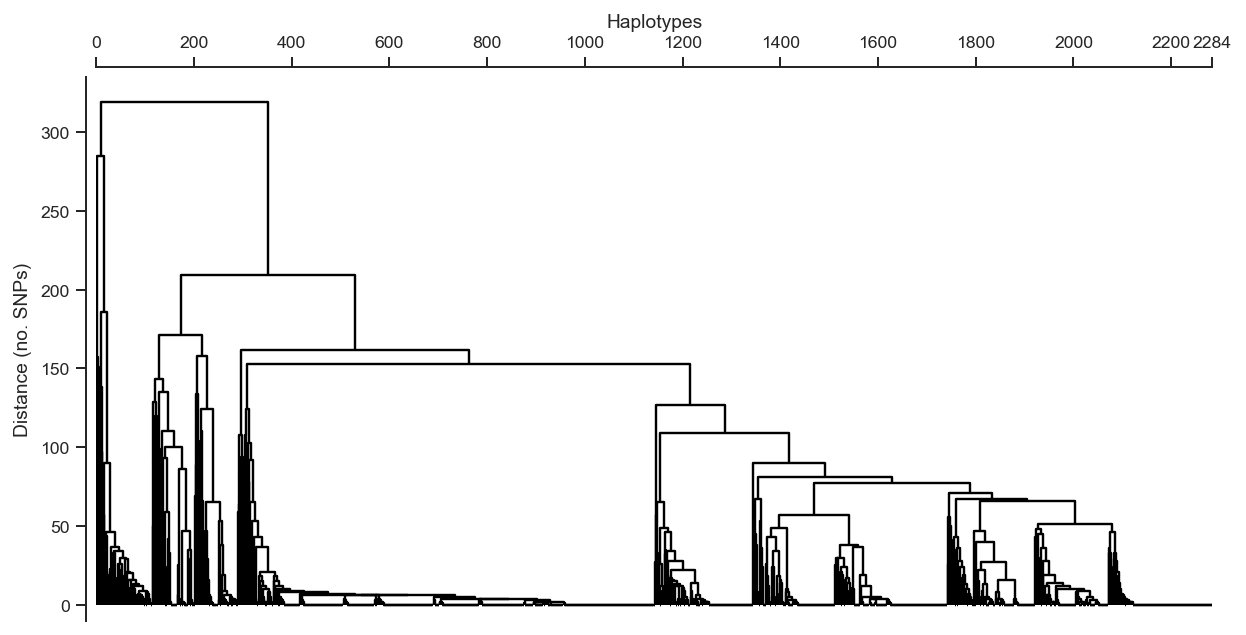

In [19]:
def plot_dendrogram(h, ax, method='complete', color_threshold=0, above_threshold_color='k'):
    
    # compute distance matrix
    dist = allel.pairwise_distance(h, 'hamming') * h.shape[0]

    # HACKING SCIPY TO GET TO OLD CLUSTERING METHOD
    # https://github.com/scipy/scipy/blob/v0.18.1/scipy/cluster/hierarchy.py#L470-L667
    # 1. fiddle with format
    y = _convert_to_double(np.asarray(dist, order='c'))
    # 2. get n
    n = int(distance.num_obs_y(dist))
    # 3. do clustering
    method = dict(single=0, complete=1)[method]
    z = _hierarchy.linkage(y, n, method)    

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(z, no_labels=True, count_sort=True, 
                                           color_threshold=color_threshold, 
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-10)
#     ax.set_xlim(left=-10)
    ax.set_ylabel('Distance (no. SNPs)')
    ax.autoscale(axis='x', tight=True)
    return z, r

fig, ax = plt.subplots(figsize=(10, 5))
plot_dendrogram(h, ax);

In [20]:
populations = phase2_ar1.pop_ids
pop_colours = phase2_ar1.pop_colors
pop_labels = phase2_ar1.pop_labels

In [21]:
df_haplotypes = pd.read_csv("../phase2.AR1/haplotypes/haplotypes.autosomes.meta.txt", sep='\t').query('population != "colony"')
df_haplotypes.head()

,Unnamed: 0,label,ox_code,population,label_aug,country,region,sex,m_s
0,0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
1,1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
2,2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
3,3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
4,4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [22]:
assert len(df_haplotypes) == h.shape[1]

In [31]:
def fig_hap_structure(h, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(10, 8), 
                      fn=None, dpi=150, height_ratios=(2.5, .2, 2.8, .2), hap_pops=None, legend=True):
    
    # create the figure
    fig = plt.figure(figsize=figsize)
    
    # define subplot layout
    gs_nrows = 4
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)
    
    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r = plot_dendrogram(h, ax_dend, color_threshold=0)
    ax_dend.set_ylim(bottom=-5)
#     for xmin, xmax in vspans:
#         ax.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), 1,
#                                    facecolor='k', edgecolor='k', alpha=.1,
#                                    transform=ax.transAxes, zorder=20))
#     ax.vlines(vspans.flat, 0, 1, transform=ax.transAxes, linestyle=':')
    if legend:
        handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
        ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = df_haplotypes.population.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [pop_colours[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')

    # missense mutations
    if h_display is not None:
        ax_mut = fig.add_subplot(gs[2, 0])
        plot_missense_haplotypes(ax_mut, h_display.take(r['leaves'], axis=1), mutations)
        ax_mut.set_xticks([])
        ax_mut.yaxis.set_tick_params(length=3, pad=2)

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[3, 0])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, h.shape[1])
    ax_clu.set_ylim(0, 1)
    for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
        if lbl:
            # hack to get the "fraction" right, which controls length of bracket arms
            fraction = -20 / (xmax - xmin)
            ax_clu.annotate("", ha='left', va='center',
                            xy=(xmin, 1), xycoords='data',
                            xytext=(xmax, 1), textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="bar,fraction=%.4f" % fraction,
                                            ),
                            )
            ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
            ax_pops.vlines([xmin, xmax], 0, 1, linestyle=':')
            ax_mut.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), h_display.shape[0],
                             facecolor='k', edgecolor='k', alpha=.1,
                             zorder=20))
            ax_mut.vlines([xmin, xmax], 0, h_display.shape[0], linestyle=':')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')
    
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
        
    return z, r

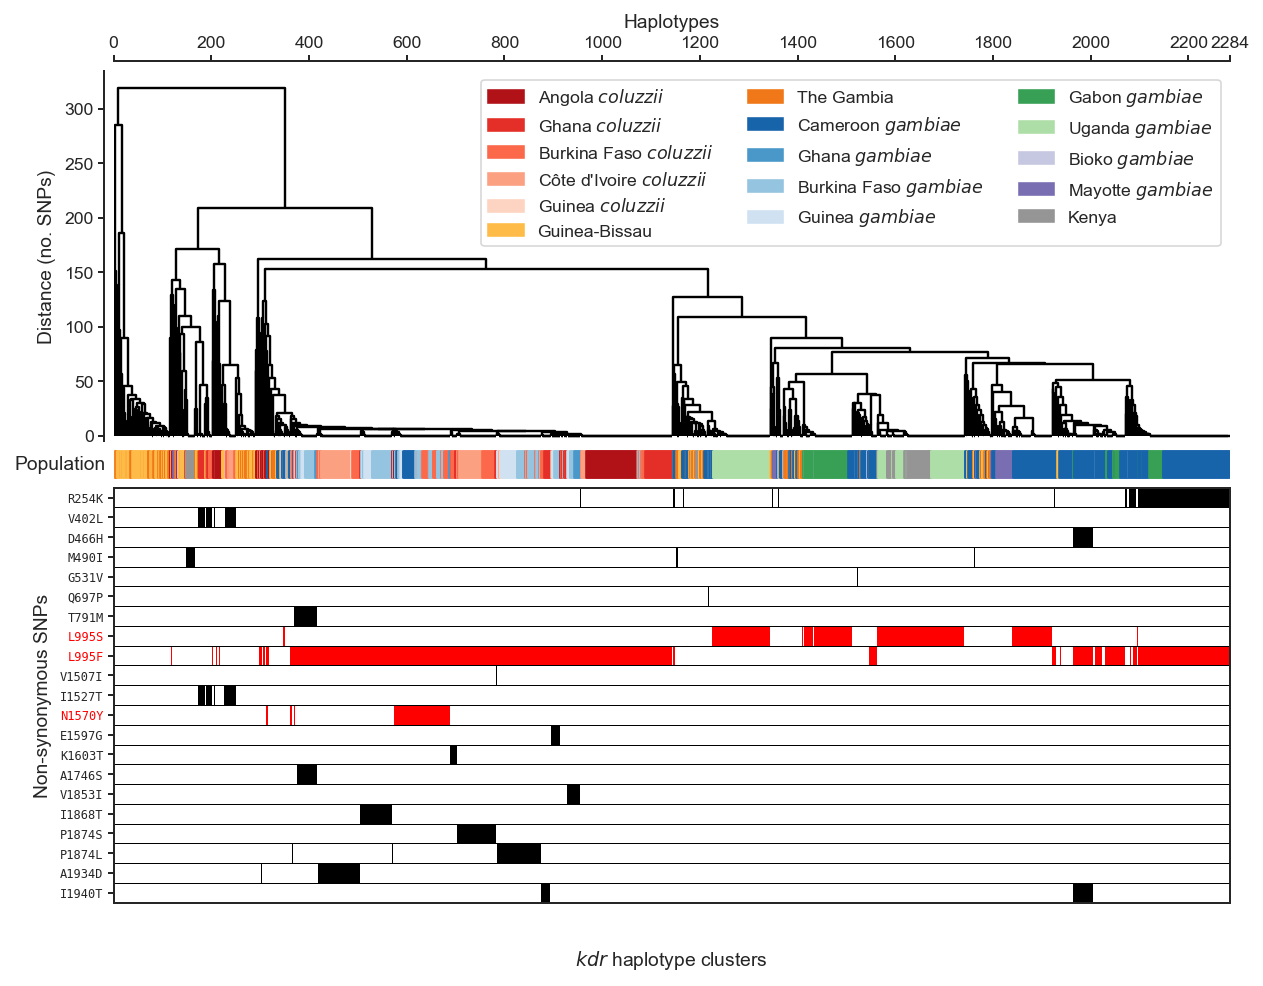

In [32]:
z, r = fig_hap_structure(h, h_missense, missense_mutations)

# questions
- the cut off for per pop allele freq is 0.05 - in small pops this drags some very low freq alleles into the plot (531, 697, 1507) - but these may be important in these small pops (GQgam, GNcol)..? Raising the cut-off means we start to lose some low freq alleles from large pops.
- should we split the multiallelics again - where is that code?
- is there anything new here?

## Cut the dendrogram

In [33]:
# gives the haplotype indices of the haplotypes in the n largest clusters
def find_clusters(z, n, threshold=15):
    
    # find clusters
    f = scipy.cluster.hierarchy.fcluster(z, threshold, criterion='distance')
    
    # compute cluster sizes
    fsz = np.bincount(f)
    
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    
    # take largest n
    fsort = fsort[:n]
    
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    
    return clusters

In [34]:
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

In [35]:
fig.get_size_inches()

array([10.,  5.])

In [36]:
#with vspans - NEEDS FIXING
def fig_hap_structure(h, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(10, 8), 
                      fn=None, dpi=150, height_ratios=(2.5, .2, 2.8, .2), hap_pops=None, legend=True):
    
    # create the figure
    fig = plt.figure(figsize=figsize)
    
    # define subplot layout
    gs_nrows = 4
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)
    
    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r = plot_dendrogram(h, ax_dend, color_threshold=0)
    ax_dend.set_ylim(bottom=-5)
    for xmin, xmax in vspans:
        ax.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), 1,
                                   facecolor='k', edgecolor='k', alpha=.1,
                                   transform=ax.transAxes, zorder=20))
    ax.vlines(vspans.flat, 0, 1, transform=ax.transAxes, linestyle=':')
    if legend:
        handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
        ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = df_haplotypes.population.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [pop_colours[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')

    # missense mutations
    if h_display is not None:
        ax_mut = fig.add_subplot(gs[2, 0])
        plot_missense_haplotypes(ax_mut, h_display.take(r['leaves'], axis=1), mutations)
        ax_mut.set_xticks([])
        ax_mut.yaxis.set_tick_params(length=3, pad=2)

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[3, 0])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, h.shape[1])
    ax_clu.set_ylim(0, 1)
    for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
        if lbl:
            # hack to get the "fraction" right, which controls length of bracket arms
            fraction = -20 / (xmax - xmin)
            ax_clu.annotate("", ha='left', va='center',
                            xy=(xmin, 1), xycoords='data',
                            xytext=(xmax, 1), textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="bar,fraction=%.4f" % fraction,
                                            ),
                            )
            ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
            ax_pops.vlines([xmin, xmax], 0, 1, linestyle=':')
            ax_mut.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), h_display.shape[0],
                             facecolor='k', edgecolor='k', alpha=.1,
                             zorder=20))
            ax_mut.vlines([xmin, xmax], 0, h_display.shape[0], linestyle=':')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')
    
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
        
    return z, r

/home/chris/malariagen/binder/conda/envs/ag1000g-phase2-vgsc-report-c668a73/lib/python3.6/site-packages/seaborn/utils.py:247: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  maj_on = any(t.tick1On for t in ax_i.xaxis.majorTicks)
/home/chris/malariagen/binder/conda/envs/ag1000g-phase2-vgsc-report-c668a73/lib/python3.6/site-packages/seaborn/utils.py:248: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  min_on = any(t.tick1On for t in ax_i.xaxis.minorTicks)
/home/chris/malariagen/binder/conda/envs/ag1000g-phase2-vgsc-report-c668a73/lib/python3.6/site-packages/seaborn/utils.py:251: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = maj_on
/home/chris/malariagen/binde

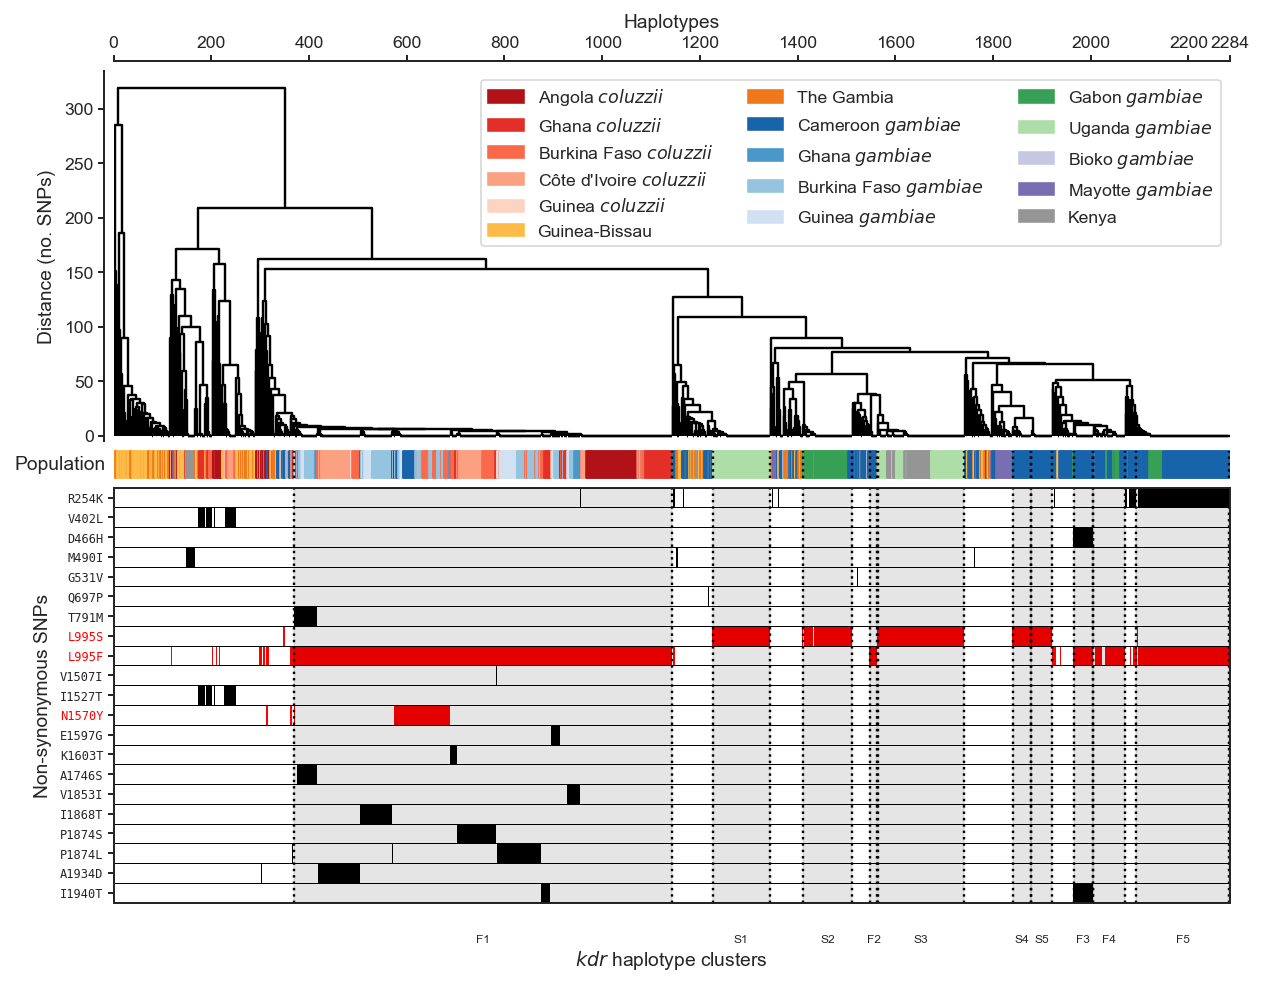

In [55]:
clustard = find_clusters(z, n=20, threshold=9)
vspans = [truspan(cluster, r) for cluster in clustard]
#cluster_labels = ['F1', 'F5', 'S3', 'S1', 'S2', 'F4', 'S5', 'F3', 'S4', '', '', 'd', '', '', 'a', '', 'F2', 'b', 'c', '']
cluster_labels = ['F1', 'F5', 'S3', 'S1', 'S2', 'F4', 'S5', 'F3', 'S4', '', '', '', '', '', '', '', 'F2', '', '', '']
fig_hap_structure(h, h_missense, mutations=missense_mutations, vspans=np.array(vspans), cluster_labels=cluster_labels);
fig = plt.gcf()
ax_dend = fig.axes[0]
#ax_dend.text(-0.08, 1.2, 'a', transform=ax_dend.transAxes, ha='left', va='top', fontsize=10, fontweight='bold')
fig.savefig('../artwork/vgsc_haplotypes_hierarchical_clustering.pdf', jpeg_quality=100, dpi=600, bbox_inches='tight')

## Generate cluster file

In [56]:
hap_sample_labels = df_haplotypes.ox_code

In [57]:
cluster_samples = dict()
for l, c in zip(cluster_labels, clustard):
    cluster_samples[l] = set(hap_sample_labels.take(list(c)))

In [58]:
def save_cluster_membership(fn, h, clusters, cluster_labels):

    # save cluster membership
    cluster_membership = np.empty(h.shape[1], dtype='S2')
    cluster_membership[:] = b''
    for cluster, lbl in zip(clusters, cluster_labels):
        hidx = sorted(cluster)
        cluster_membership[hidx] = lbl.encode('ascii')[:2]

    np.save(fn, cluster_membership)

In [59]:
save_cluster_membership('../data/hierarchical_cluster_membership.npy', h, clustard, cluster_labels)